In [2]:
import numpy as np
import matplotlib.pyplot as plt

from boost_histogram import Histogram
from boost_histogram.axis import Regular

import sys
sys.path.append('src')

from sts_sensor import StsSensor
from sts_track import StsTrack
from particle_gun import ParticleGun

from fitters import fit_least_squares

In [3]:
def real_trajectory(track: StsTrack, sensors: list, n_points=100):
    z = np.linspace(sensors[0].z, sensors[-1].z, n_points)
    x = track.x + track.tx * (z - track.x)
    y = track.y + track.ty * (z - track.y)
    return x, y, z

def measured_trajectory(track: StsTrack, sensors: list):
    measurements = []
    for sensor in sensors:
        # Calculate intersection with the sensor plane
        if track.tz == 0:
            continue  # Avoid division by zero

        x_intersect = track.x + track.tx * (sensor.z - track.x)
        y_intersect = track.y + track.ty * (sensor.z - track.y)

        # Smear measurements by sensor resolution
        x_intersect += np.random.normal(0, sensor.res_x)
        y_intersect += np.random.normal(0, sensor.res_y)

        # Check if within sensor bounds
        if (sensor.x - sensor.dx/2 <= x_intersect <= sensor.x + sensor.dx/2 and
            sensor.y - sensor.dy/2 <= y_intersect <= sensor.y + sensor.dy/2):
            measurements.append((x_intersect, y_intersect, sensor.z))
        else:
            measurements.append(None)

    return measurements


In [4]:
draw = False  # Set to True to enable plotting

sensors = [StsSensor((0,0,10*i), 6, 0, 0, (0.1, 0.01, 0.0)) for i in range(8)]

h_res_rho = [Histogram(Regular(100, -0.5, +0.5)) for _ in sensors]
if draw:
    # Plotting the sensors edges in 3D space
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for sensor in sensors:
        ax.plot([sensor.x - sensor.dx/2, sensor.x + sensor.dx/2, sensor.x + sensor.dx/2, sensor.x - sensor.dx/2, sensor.x - sensor.dx/2],
                [sensor.y - sensor.dy/2, sensor.y - sensor.dy/2, sensor.y + sensor.dy/2, sensor.y + sensor.dy/2, sensor.y - sensor.dy/2],
                [sensor.z, sensor.z, sensor.z, sensor.z, sensor.z], color='blue', alpha=0.5)
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_zlabel('Z (cm)')

particles = ParticleGun(r0=[.0, .0, .0], dr=[.0, .0, 0], p0=[0, 0, 1], dp=[.03, .03, .0], mass=0.938).generate(100)

for p in particles:
    x_real, y_real, z_real = real_trajectory(p, sensors)
    measurement = measured_trajectory(p, sensors)

    if draw:
        # Plot reatl trajectory
        ax.plot(x_real, y_real, z_real, 'g--', label='Real Trajectory')

    # Fit the 3D line to the hits
    points_to_fit = [hit for hit in measurement if hit is not None]
    if len(points_to_fit) > 1:
        r0, tx, ty, residuals = fit_least_squares(points_to_fit)

        # Fill the histogram with residuals
        for i, res in enumerate(residuals):
            h_res_rho[i].fill(res)

        if draw:
            # building the fitted line
            z = np.linspace(points_to_fit[0][2], points_to_fit[-1][2], 100)
            x = points_to_fit[0][0] + tx * (z - points_to_fit[0][0])
            y = points_to_fit[0][1] + tx * (z - points_to_fit[0][1])

            ax.plot(x, y, z, 'r-', label='Fitted Line')
            # print(f"[{r0[0]:.4f}, {r0[1]:.4f}, {r0[2]:.4f}], [{tx:.4f}, {ty:.4f}, 1]\n{residuals}")
    else:
        print("Not enough hits to fit a line.")

    if draw:
        # Plotting the trajectory in 3D space
        for hit in points_to_fit:
            ax.plot([hit[0]], [hit[1]], [hit[2]], 'bo', label='Hit')
        ax.set_xlabel('X (cm)')
        ax.set_ylabel('Y (cm)')
        ax.set_zlabel('Z (cm)')

        # Plot XZ projection
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.scatter([p[2] for p in points_to_fit], [p[0] for p in points_to_fit], label='Hits')
        plt.plot(z, x, 'r-', label='Fitted Line')
        plt.xlabel('Z (cm)')
        plt.ylabel('X (cm)')
        plt.title('XZ Projection')
        plt.legend()

        # Plot YZ projection
        plt.subplot(1, 2, 2)
        plt.scatter([p[2] for p in points_to_fit], [p[1] for p in points_to_fit], label='Hits')
        plt.plot(z, y, 'r-', label='Fitted Line')
        plt.xlabel('Z (cm)')
        plt.ylabel('Y (cm)')
        plt.title('YZ Projection')
        plt.legend()



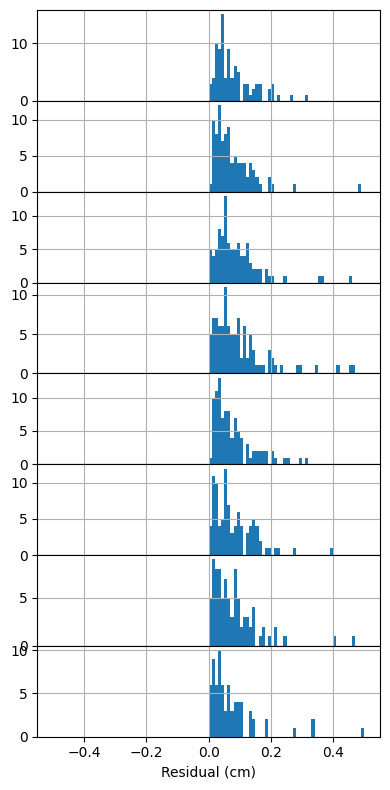

In [5]:
fig, axes = plt.subplots(len(h_res_rho), 1, figsize=(4, 1 * len(h_res_rho)), sharex=True, gridspec_kw={'hspace': 0})

for ax, hist in zip(axes, h_res_rho):
    ax.bar(hist.axes[0].centers, hist.values(), width=hist.axes[0].widths, align='center')
    ax.set_ylabel("")
    ax.grid(True)

axes[-1].set_xlabel("Residual (cm)")
plt.tight_layout()
plt.show()